# Classifying breast tumors using FFNN 

## Set up

### Importing libraries

In [1]:
import sys
import os

import pandas as pd

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

In [2]:
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from torch import nn, optim, tensor
from Neural_Network_with_PyTorch import Neural_Network_PyTorch

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from copy import deepcopy

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

### Initialize data

In [3]:
from sklearn.datasets import load_breast_cancer
# Load the data
cancer = load_breast_cancer()
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)
true_X = cancer.data
true_target = torch.from_numpy(cancer.target).float()
true_target = true_target.reshape(true_target.shape[0], 1)

In [4]:
test_size = 0.2
true_X_train, true_X_test, true_target_train, true_target_test = train_test_split(true_X, true_target, test_size=test_size)

### Exploratory datanalysis

In [5]:
print('true_X_train',true_X_train.shape)
print('true_X_test',true_X_test.shape)
print('true_target_train', true_target_train.shape)
print('true_target_test', true_target_test.shape)

true_X_train (455, 30)
true_X_test (114, 30)
true_target_train torch.Size([455, 1])
true_target_test torch.Size([114, 1])


In [6]:
pd.DataFrame(true_X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.142644,19.361077,92.071604,655.691648,0.096483,0.104334,0.089595,0.048912,0.181468,0.062807,...,16.281978,25.865758,107.467231,881.310330,0.132937,0.256056,0.277551,0.114850,0.290115,0.084244
std,3.493656,4.307275,24.057464,348.441941,0.014051,0.052324,0.080075,0.038699,0.027123,0.006996,...,4.797071,6.230573,33.444469,563.771365,0.023266,0.161561,0.215393,0.065959,0.060513,0.018717
min,6.981000,10.380000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.490000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.740000,16.210000,75.500000,424.800000,0.086390,0.063750,0.029035,0.020220,0.162050,0.057945,...,13.065000,21.355000,84.530000,517.950000,0.117100,0.147750,0.115450,0.064530,0.252000,0.071370
50%,13.340000,18.890000,86.600000,546.300000,0.095790,0.094450,0.061950,0.033840,0.179200,0.061440,...,14.970000,25.480000,97.670000,686.500000,0.131200,0.214100,0.231000,0.101000,0.282600,0.080090
75%,15.755000,21.875000,103.750000,782.650000,0.105400,0.130550,0.132350,0.072020,0.195700,0.066120,...,18.530000,30.080000,124.650000,1039.500000,0.146350,0.335800,0.387200,0.162650,0.317550,0.092055
max,28.110000,33.810000,188.500000,2499.000000,0.144700,0.311400,0.426800,0.201200,0.304000,0.097440,...,33.130000,49.540000,229.300000,3432.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


From the summarization we see a wide spread in data magnitude, we performe a standard scaling using the estimated standard deviation.

In [7]:
# Using the StandardScaler from scikit learn
# Create an instance of StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data
scaler.fit(true_X_train)
# Transform the training data
true_X_train = torch.from_numpy(scaler.transform(true_X_train)).float()
# Transform the test data
true_X_test = torch.from_numpy(scaler.transform(true_X_test)).float()

In [8]:
pd.DataFrame(true_X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,4.550000e+02,4.550000e+02,4.550000e+02,455.000000,4.550000e+02,4.550000e+02,4.550000e+02,455.000000,4.550000e+02,4.550000e+02,...,4.550000e+02,455.000000,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,455.000000,4.550000e+02,4.550000e+02
mean,4.191975e-09,6.287963e-09,4.191975e-09,0.000000,-4.191975e-09,2.095988e-09,2.095988e-09,0.000000,4.191975e-09,-2.095988e-09,...,-1.047994e-09,0.000000,8.383950e-09,3.143981e-09,8.383950e-09,-6.287963e-09,-6.287963e-09,0.000000,-4.191975e-09,2.095988e-09
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101,1.001101e+00,1.001101e+00,1.001101e+00,1.001101,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001100,1.001100e+00,1.001101e+00,1.001100e+00,1.001101e+00,1.001101e+00,1.001101,1.001101e+00,1.001101e+00
min,-2.052156e+00,-2.087390e+00,-2.009137e+00,-1.471566,-3.124498e+00,-1.625398e+00,-1.120117e+00,-1.265291,-2.785498e+00,-1.838462e+00,...,-1.742974e+00,-2.149157,-1.707907e+00,-1.236098e+00,-2.657705e+00,-1.417530e+00,-1.290001e+00,-1.743144,-2.210481e+00,-1.561978e+00
25%,-6.884732e-01,-7.323761e-01,-6.895924e-01,-0.663370,-7.191167e-01,-7.764829e-01,-7.571194e-01,-0.742222,-7.167034e-01,-6.957746e-01,...,-6.713511e-01,-0.724768,-6.865852e-01,-6.452266e-01,-6.814277e-01,-6.711109e-01,-7.534134e-01,-0.763731,-6.305582e-01,-6.885653e-01
50%,-2.299961e-01,-1.094881e-01,-2.276893e-01,-0.314291,-4.937195e-02,-1.891111e-01,-3.456142e-01,-0.389887,-8.370009e-02,-1.956251e-01,...,-2.737967e-01,-0.061982,-2.932627e-01,-3.459288e-01,-7.473258e-02,-2.599793e-01,-2.163614e-01,-0.210203,-1.243213e-01,-2.221749e-01
75%,4.620176e-01,5.842882e-01,4.859718e-01,0.364761,6.353352e-01,5.015768e-01,5.345305e-01,0.597787,5.253118e-01,4.741029e-01,...,4.691397e-01,0.677126,5.143357e-01,2.809007e-01,5.771419e-01,4.941234e-01,5.096232e-01,0.725498,4.538807e-01,4.177748e-01
max,4.002320e+00,3.358232e+00,4.012665e+00,5.295968,3.435438e+00,3.961713e+00,4.215761e+00,3.939532,4.522644e+00,4.956129e+00,...,3.516014e+00,3.803871,3.646847e+00,4.529314e+00,3.858028e+00,4.969169e+00,4.529031e+00,2.673548,6.182133e+00,6.592366e+00


observing the new mean value we are now $\approx$ zero centered and we have most observations within $\pm 1 (\approx 1\hat\sigma)$.

Now let us take a look at the correlation matrix of the data.

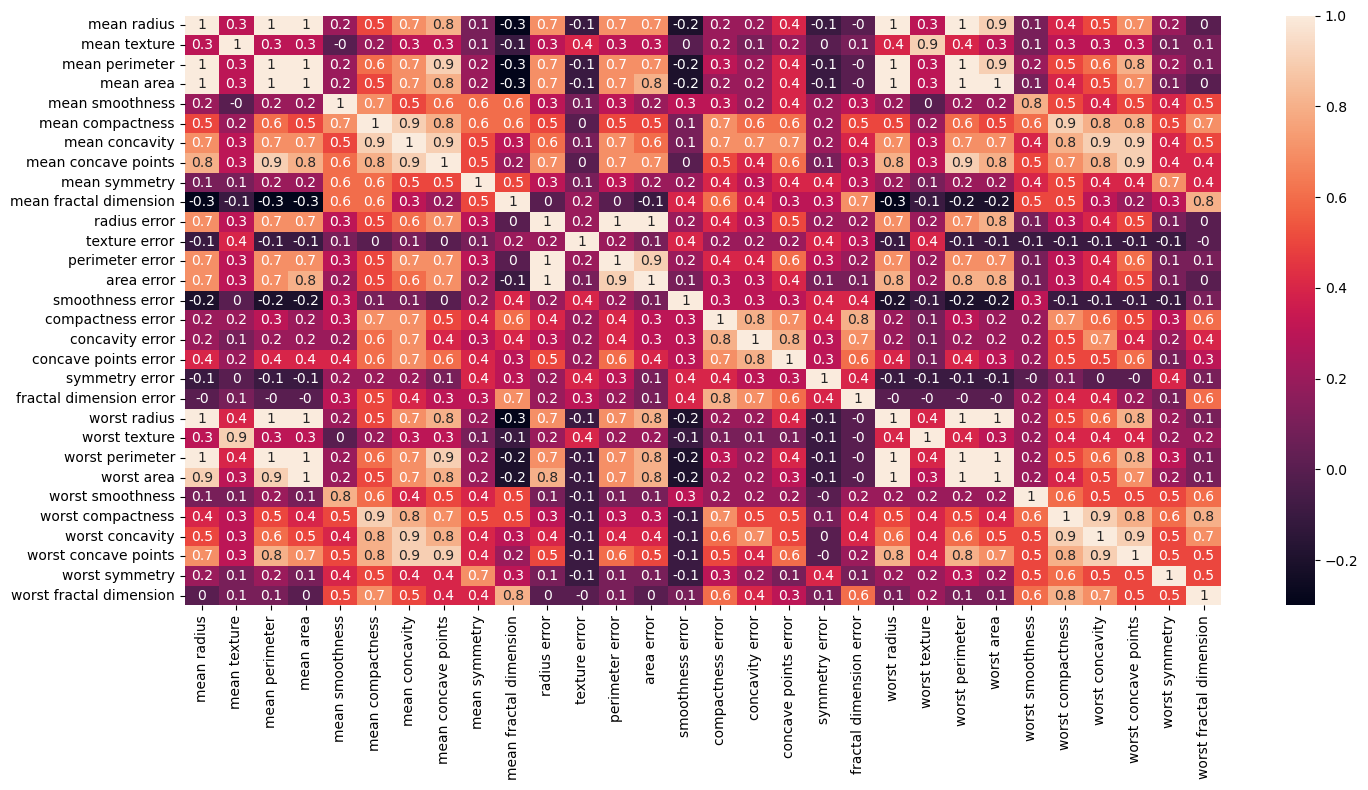

In [18]:
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.tight_layout()
plt.savefig(r"Figures\Task_d\Cancer_data_correlation_matrix.png")
plt.show()

We see that there are some highly correlated features, we will not remove any of these as we are using a FFNN which should be able to handle this correlation.

## Set up and tune FFNN

### Support functions

For parameter tuning we use

In [10]:
def train_with_crossval(train_X, train_target, 
                        n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                        activation_hidden, 
                        learning_rate, l2_reg, 
                        num_epochs, n_minibatches):
    torch.manual_seed(1234)
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    # Initialize the evaluation metrices
    accuracy_score_crossval = []
    accuracy_score_crossval_train = []
    # Loop over the folds
    for train_idx, val_idx in kf.split(train_X):
        # Extract training and validation data
        X_train, target_train = train_X[train_idx], train_target[train_idx]
        X_val, target_val = train_X[val_idx], train_target[val_idx]
        
        # Create new network
        ffnn = Neural_Network_PyTorch(n_features, 
                                      n_hidden_layers, n_hidden_nodes, 
                                      n_outputs, 
                                      activation_function_hidden_layers=activation_hidden, 
                                      activation_function_output_layer=None)
        
        # Loss function
        criterion = nn.MSELoss()
        # Optimizer
        optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=l2_reg)
        
        # Train the network            
        ffnn = ffnn.train_network(X_train, target_train, 
                                  optimizer, criterion,
                                  num_iter=num_epochs, n_minibatches=n_minibatches)
        # Evaluate the network
        # Train performance
        target_train_pred = torch.tensor(ffnn.classify(ffnn.feed_forward(X_train))).reshape(-1, 1)
        accuracy_score_crossval_train.append(accuracy_score(target_train, target_train_pred))
        # Validation performance
        ffnn.eval() # set model in evaluation mode
        with torch.no_grad(): # disable gradient computation
            target_val_pred = ffnn.feed_forward(X_val)
            target_val_pred = ffnn.classify(target_val_pred)
            accuracy_score_crossval.append(accuracy_score(target_val, target_val_pred))
            
    
    return ffnn, accuracy_score_crossval, accuracy_score_crossval_train

for heatmap visualization we use

In [13]:
def plot_heatmap(accuracy_scores, 
                 dataset_name,
                 x_label, y_label,
                 x_ticks, y_ticks,
                 filename=None):
    
    fig, ax = plt.subplots(figsize=(5, 4))
    heatmap = sns.heatmap(accuracy_scores, annot=True, 
                          fmt=".4f",
                          ax=ax, cmap="viridis")
    heatmap.set_xticklabels(x_ticks)
    heatmap.set_yticklabels(y_ticks)
    ax.set_title("Accuracy" + dataset_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

### Initial setup

In [22]:
n_hidden_layers = 2
n_hidden_nodes = 2
n_outputs = 1
n_features = true_X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate_space = np.logspace(-4, 0, 5)
lmbd = 0.0001
n_epochs = 50
n_minibatches = 32

In [24]:
torch.manual_seed(seed)
# Initialize the evaluation metrices
accuracy_score_val = np.zeros((len(learning_rate_space), 1))
accuracy_score_train = np.zeros((len(learning_rate_space), 1))

for i, learning_rate in enumerate(learning_rate_space):
    print(f"Learning rate: {learning_rate}")

    (ffnn, 
     accuracy_score_crossval, 
     accuracy_score_crossval_train) = train_with_crossval(true_X_train, true_target_train, 
                                                          n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                                          activation_hidden, 
                                                          learning_rate, lmbd, 
                                                          n_epochs, n_minibatches)
    
    accuracy_score_val[i][0] = np.median(accuracy_score_crossval)
    accuracy_score_train[i][0] = np.median(accuracy_score_crossval_train)
    

Learning rate: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067F527880>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067EDFB740>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B380>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x00000206119F7920>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067EDFB740>
Learning rate: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x00000206119F7920>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F2C31A0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B600>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020611A3F060>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F2C31A0>
Learnin

In [26]:
best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val==np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.4f} yielded by best learning rate: {learning_rate_space[best_val_accuracy_idx[0][0]]}")

print(accuracy_score_val)
print(accuracy_score_train)

Best acc: 0.9670 yielded by best learning rate: 0.001
[[0.62637363]
 [0.96703297]
 [0.96703297]
 [0.94505495]
 [0.61538462]]
[[0.62637363]
 [0.97527473]
 [0.98901099]
 [0.95879121]
 [0.62637363]]


The lr of .01 and .001 yields similar results. We will keep lr = 0.01 since it has the lowest difference between the validation accuracy and the training accuracy. We keep this while tuning and retune it at the end simultaniously as l2 regularization.

### Tune epochs and minibatches

In [27]:
n_hidden_layers = 2
n_hidden_nodes = 2
n_outputs = 1
n_features = true_X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate = 0.01
lmbd = 0.0001
n_epochs_space = [50, 100, 150, 200]
n_minibatches_space = [8, 16, 32, 64]

In [28]:
# Initialize the evaluation metrices
accuracy_score_val = np.zeros((len(n_epochs_space), len(n_minibatches_space)))
accuracy_score_train = np.zeros((len(n_epochs_space), len(n_minibatches_space)))

for i, n_epochs in enumerate(n_epochs_space):
    print(f"n epochs: {n_epochs}")
    for j, n_minibatches in enumerate(n_minibatches_space):
        print(f"n minibatches: {n_minibatches}")
        (ffnn, 
         accuracy_score_crossval, 
         accuracy_score_crossval_train) = train_with_crossval(true_X_train, true_target_train, 
                                                              n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                                              activation_hidden, 
                                                              learning_rate, lmbd, 
                                                              n_epochs, n_minibatches)
        
        accuracy_score_val[i][j] = np.median(accuracy_score_crossval)
        accuracy_score_train[i][j] = np.median(accuracy_score_crossval_train)
        

n epochs: 50
n minibatches: 8
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067F527880>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F595D00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B1A0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F990720>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F595D00>
n minibatches: 16
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F990720>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067F527880>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B380>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x00000206119F7920>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002067F527880>
n 

In [30]:
best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best number of epochs:    {n_epochs_space[best_val_accuracy_idx[0][0]]} and best number of minibatches: {n_minibatches_space[best_val_accuracy_idx[1][0]]}")
print(accuracy_score_val)
print(accuracy_score_train)

Best acc: 0.99 yielded by best number of epochs:    100 and best number of minibatches: 8
[[0.96703297 0.97802198 0.96703297 0.96703297]
 [0.98901099 0.97802198 0.97802198 0.97802198]
 [0.97802198 0.98901099 0.97802198 0.97802198]
 [0.96703297 0.96703297 0.97802198 0.97802198]]
[[0.98351648 0.98626374 0.98901099 0.99175824]
 [0.98626374 0.98901099 0.99450549 0.99725275]
 [0.99175824 0.99450549 0.99450549 0.99725275]
 [0.99175824 0.99450549 0.99450549 0.99725275]]


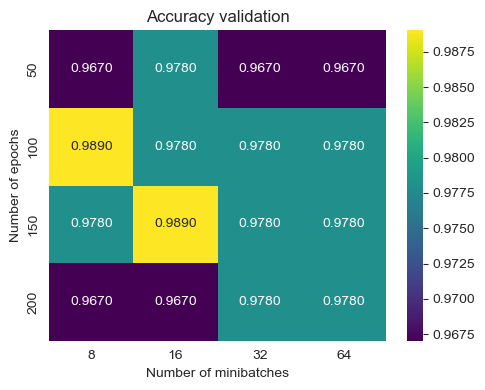

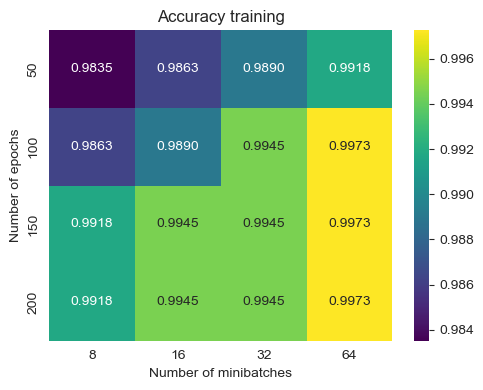

In [38]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="Number of minibatches",
             y_label="Number of epochs",
             x_ticks=n_minibatches_space,
             y_ticks=n_epochs_space)
plot_heatmap(accuracy_score_train, 
             dataset_name=" training",
             x_label="Number of minibatches",
             y_label="Number of epochs",
             x_ticks=n_minibatches_space,
             y_ticks=n_epochs_space)

We are using the validation set as a meassure of the generalization error. We see that the best accuracy is achieved with 100 epochs and 8 minibatches or 150 epochs and 16 minibatches. We will keep the 100 epochs and 8 minibatches as it is the lowest number of epochs and minibatches which speeds up the training and reduces the risk of overfitting.

### Tune number of hidden layers and nodes

In [39]:
n_hidden_layers_space = [2, 3, 4]
n_hidden_nodes_space = [10, 30, 50]
n_outputs = 1
n_features = true_X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate_space = 0.01
lmbd = 0.0001
n_epochs = 100
n_minibatches = 8

In [40]:
# Initialize the evaluation metrices
accuracy_score_val = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))
accuracy_score_train = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))

for i, n_hidden_layers in enumerate(n_hidden_layers_space):
    print(f"n hidden layers: {n_hidden_layers}")
    for j, n_hidden_nodes in enumerate(n_hidden_nodes_space):
        print(f"n hidden nodes: {n_hidden_nodes}")
        (ffnn, 
         accuracy_score_crossval, 
         accuracy_score_crossval_train) = train_with_crossval(true_X_train, true_target_train, 
                                                              n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                                              activation_hidden, 
                                                              learning_rate, lmbd, 
                                                              n_epochs, n_minibatches)
        
        accuracy_score_val[i][j] = np.median(accuracy_score_crossval)
        accuracy_score_train[i][j] = np.median(accuracy_score_crossval_train)

n hidden layers: 2
n hidden nodes: 10
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F595D00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612FC7100>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B380>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F595D00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B600>
n hidden nodes: 30
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F595D00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F990720>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612FC54E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000020612C4B380>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000002060F9

In [41]:
best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best number of hidden layers:    {n_hidden_layers_space[best_val_accuracy_idx[0][0]]} and best number of nodes: {n_hidden_nodes_space[best_val_accuracy_idx[1][0]]}")

Best acc: 1.00 yielded by best number of hidden layers:    2 and best number of nodes: 50


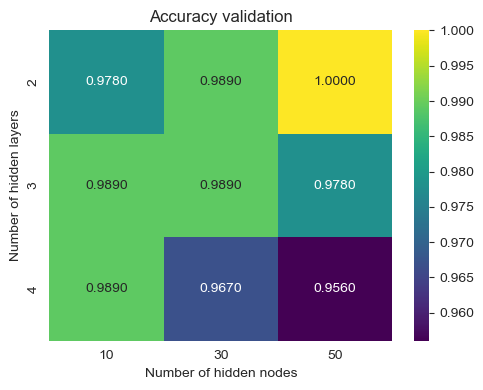

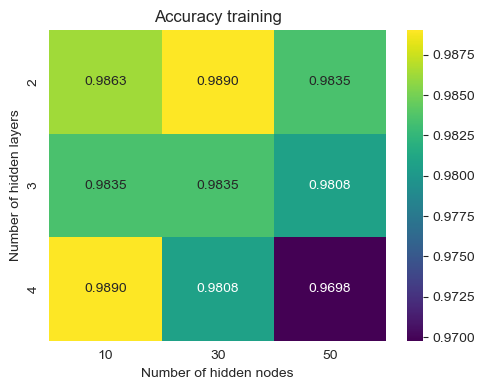

In [42]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="Number of hidden nodes",
             y_label="Number of hidden layers",
             x_ticks=n_hidden_nodes_space,
             y_ticks=n_hidden_layers_space)
plot_heatmap(accuracy_score_train,
             dataset_name=" training",
             x_label="Number of hidden nodes",
             y_label="Number of hidden layers",
             x_ticks=n_hidden_nodes_space,
             y_ticks=n_hidden_layers_space)

We see that the best accuracy is achieved with 2 hidden layers and 50 hidden nodes. We will keep this. 

### Tuning lambda and learning rate for different activation functions

In [14]:
n_hidden_layers = 2
n_hidden_nodes = 50
n_outputs = 1
n_features = true_X_train.shape[1]
activation_hidden_space = ["sigmoid", 'tanh', 'ReLU', 'Leaky ReLU']  
learning_rate_space = np.logspace(-4, 0, 5)
lmbd_space = np.insert(np.logspace(-5, -2, 4), 0, 0.0)
n_epochs = 100
n_minibatches = 8

In [15]:
d = {}
for activation_hidden in activation_hidden_space:
    print(f"Activation hidden: {activation_hidden}")
    # Initialize the evaluation metrices
    accuracy_score_val = np.zeros((len(learning_rate_space), len(lmbd_space)))
    accuracy_score_train = np.zeros((len(learning_rate_space), len(lmbd_space)))
    
    for i, learning_rate in enumerate(learning_rate_space):
        print(f"Learning rate: {learning_rate}")
        for j, lmbd in enumerate(lmbd_space):
            print(f"L2 regularization: {lmbd}")
            (ffnn, 
             accuracy_score_crossval, 
             accuracy_score_crossval_train) = train_with_crossval(true_X_train,                                                                     true_target_train, 
                                                                  n_features, n_hidden_layers,
                                                                  n_hidden_nodes, n_outputs, 
                                                                  activation_hidden, 
                                                                  learning_rate, lmbd, 
                                                                  n_epochs, n_minibatches)
            
            accuracy_score_val[i][j] = np.median(accuracy_score_crossval)
            accuracy_score_train[i][j] = np.median(accuracy_score_crossval_train)
    d[activation_hidden] = [accuracy_score_val, accuracy_score_train]

Activation hidden: sigmoid
Learning rate: 0.0001
L2 regularization: 0.0
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
L2 regularization: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
L2 regularization: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
L2 regularization: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FF40>

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
L2 regularization: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FF40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
L2 regularization: 0.01
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FF40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<

L2 regularization: 0.01
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
Activation hidden: ReLU
Learning rate: 0.0001
L2 regularization: 0.0
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FF40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_func

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
L2 regularization: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757BE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
L2 regularization: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
L2 regularization: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
L2 regularization: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>

L2 regularization: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FE20>
L2 regularization: 0.01
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347757EB0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F347896680>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F348F6FEB0>


#### Sigmoid activation function

In [19]:
performance_matrices = d['sigmoid']
accuracy_score_val = performance_matrices[0]
accuracy_score_train = performance_matrices[1]

best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best learning rate:    {learning_rate_space[best_val_accuracy_idx[0][0]]} and best l2 value: {lmbd_space[best_val_accuracy_idx[1][0]]}")

Best acc: 1.00 yielded by best learning rate:    0.01 and best l2 value: 0.0001


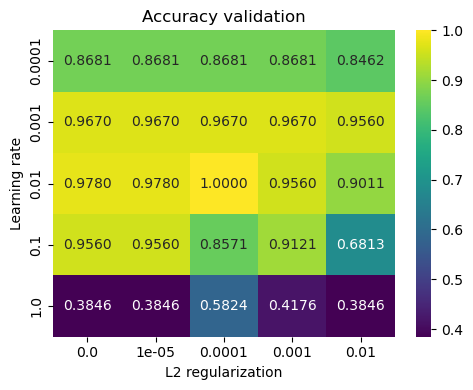

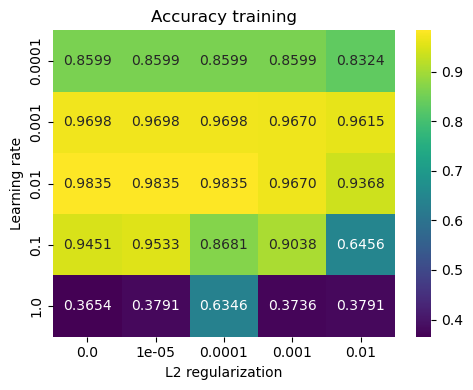

In [17]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="L2 regularization",
             y_label="Learning rate",
             x_ticks=lmbd_space,
             y_ticks=learning_rate_space,
             filename = r"Figures\Task_d\Cancer_tune_lambda_lr_accuracy_pytorch.png")
plot_heatmap(accuracy_score_train,
                dataset_name=" training",
                x_label="L2 regularization",
                y_label="Learning rate",
                x_ticks=lmbd_space,
                y_ticks=learning_rate_space)

#### Tanh activation function

In [60]:
performance_matrices = d['tanh']
accuracy_score_val = performance_matrices[0]
accuracy_score_train = performance_matrices[1]

best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best learning rate:    {learning_rate_space[best_val_accuracy_idx[0][0]]} and best l2 value: {lmbd_space[best_val_accuracy_idx[1][0]]}")

Best acc: 0.98 yielded by best learning rate:    0.001 and best l2 value: 0.0


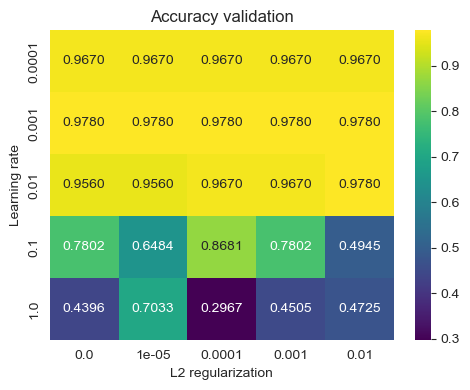

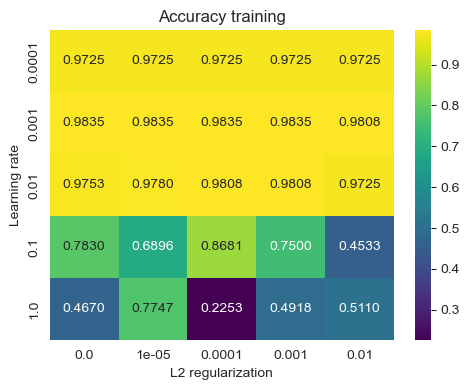

In [54]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="L2 regularization",
             y_label="Learning rate",
             x_ticks=lmbd_space,
             y_ticks=learning_rate_space)
plot_heatmap(accuracy_score_train,
                dataset_name=" training",
                x_label="L2 regularization",
                y_label="Learning rate",
                x_ticks=lmbd_space,
                y_ticks=learning_rate_space)

#### ReLU activation function

In [61]:
performance_matrices = d['ReLU']
accuracy_score_val = performance_matrices[0]
accuracy_score_train = performance_matrices[1]

best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best learning rate:    {learning_rate_space[best_val_accuracy_idx[0][0]]} and best l2 value: {lmbd_space[best_val_accuracy_idx[1][0]]}")

Best acc: 0.99 yielded by best learning rate:    0.01 and best l2 value: 0.0


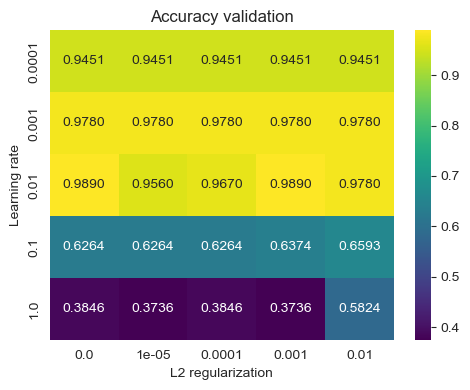

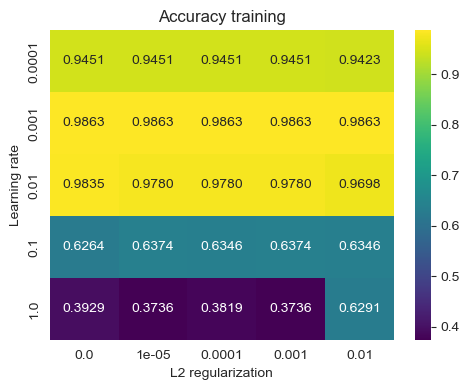

In [56]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="L2 regularization",
             y_label="Learning rate",
             x_ticks=lmbd_space,
             y_ticks=learning_rate_space)
plot_heatmap(accuracy_score_train,
                dataset_name=" training",
                x_label="L2 regularization",
                y_label="Learning rate",
                x_ticks=lmbd_space,
                y_ticks=learning_rate_space)

#### Leaky ReLU activation function

In [62]:
performance_matrices = d['Leaky ReLU']
accuracy_score_val = performance_matrices[0]
accuracy_score_train = performance_matrices[1]

best_val_accuracy = np.max(accuracy_score_val)
best_val_accuracy_idx = np.where(accuracy_score_val == np.max(accuracy_score_val))
print(f"Best acc: {best_val_accuracy:.2f} yielded by best learning rate:    {learning_rate_space[best_val_accuracy_idx[0][0]]} and best l2 value: {lmbd_space[best_val_accuracy_idx[1][0]]}")

Best acc: 0.98 yielded by best learning rate:    0.001 and best l2 value: 0.01


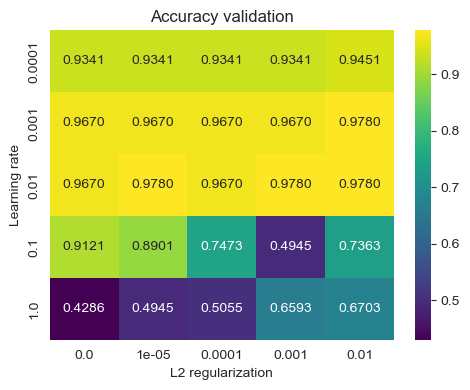

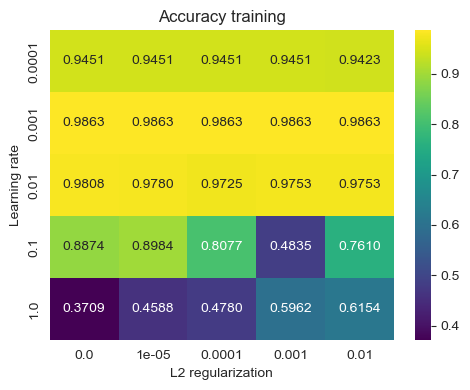

In [58]:
plot_heatmap(accuracy_score_val, 
             dataset_name=" validation",
             x_label="L2 regularization",
             y_label="Learning rate",
             x_ticks=lmbd_space,
             y_ticks=learning_rate_space)
plot_heatmap(accuracy_score_train,
                dataset_name=" training",
                x_label="L2 regularization",
                y_label="Learning rate",
                x_ticks=lmbd_space,
                y_ticks=learning_rate_space)

## Retrain model with "optimal" hyperparameters

In [20]:
n_hidden_layers = 2
n_hidden_nodes = 50
n_outputs = 1
n_features = true_X_train.shape[1]
activation_hidden_space = "sigmoid"
learning_rate = .01
lmbd = .0001
n_epochs = 100
n_minibatches = 8

In [25]:
ffnn = Neural_Network_PyTorch(n_features, 
                              n_hidden_layers, n_hidden_nodes, 
                              n_outputs, 
                              activation_function_hidden_layers=activation_hidden_space, 
                              activation_function_output_layer=None)
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=lmbd)

# Train the network
ffnn = ffnn.train_network(true_X_train, true_target_train, 
                          optimizer, criterion,
                          num_iter=n_epochs, n_minibatches=n_minibatches)
ffnn.eval()
with torch.no_grad():
    training_classification = ffnn.classify(ffnn.feed_forward(true_X_train))
    test_classification = ffnn.classify(ffnn.feed_forward(true_X_test))


<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001F337FEFD00>


In [26]:
print(f"Training accuracy: {accuracy_score(true_target_train, training_classification):.4f}")
print(f"Test accuracy: {accuracy_score(true_target_test, test_classification):.4f}")

Training accuracy: 0.9648
Test accuracy: 0.9561


The difference between the training accuracy and the test accuracy is small, this indicates that we have not overfitted the model and that the generalization error is quite low. 

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
tn, fp, fn, tp = confusion_matrix(true_target_test, test_classification).ravel()
conf_matrix = [[tp, fp], [fn, tn]]

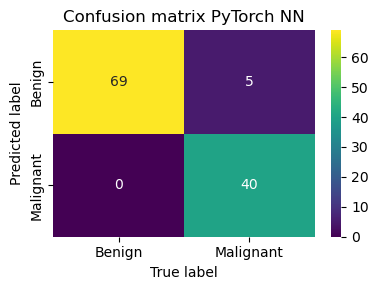

In [36]:
fig, ax = plt.subplots(figsize = (4, 3))
heatmap = sns.heatmap(conf_matrix, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(["Benign", "Malignant"])
heatmap.set_yticklabels(["Benign", "Malignant"])
ax.set_title("Confusion matrix PyTorch NN")
ax.set_ylabel("Predicted label")
ax.set_xlabel("True label")
plt.tight_layout()
plt.savefig(r"Figures\Task_d\Cancer_confusion_matrix_PyTorch_test.png")
plt.show()

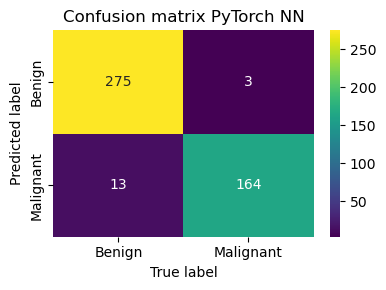

In [37]:
tn, fp, fn, tp = confusion_matrix(true_target_train, training_classification).ravel()
conf_matrix = [[tp, fp], [fn, tn]]

fig, ax = plt.subplots(figsize = (4, 3))
heatmap = sns.heatmap(conf_matrix, annot=True, ax=ax, fmt=".0f", cmap="viridis")
heatmap.set_xticklabels(["Benign", "Malignant"])
heatmap.set_yticklabels(["Benign", "Malignant"])
ax.set_title("Confusion matrix PyTorch NN")
ax.set_ylabel("Predicted label")
ax.set_xlabel("True label")
plt.tight_layout()
plt.savefig(r"Figures\Task_d\Cancer_confusion_matrix_PyTorch_train.png")
plt.show()

# Compare with logistic regression

We use the same data as before but now we use logistic regression to do the prediction.

In [38]:
logreg = linear_model.LogisticRegression()

In [39]:
logreg.fit(true_X_train, true_target_train.ravel())
log_reg_test_pred = logreg.predict(true_X_test)

In [40]:
test_accuracy_logreg = accuracy_score(true_target_test, log_reg_test_pred)
print(f"Test accuracy using logreg: {test_accuracy_logreg:.4f}")

Test accuracy using logreg: 0.9561


In [41]:
tn, fp, fn, tp = confusion_matrix(true_target_test, log_reg_test_pred).ravel()
conf_matrix = [[tp, fp], [fn, tn]]

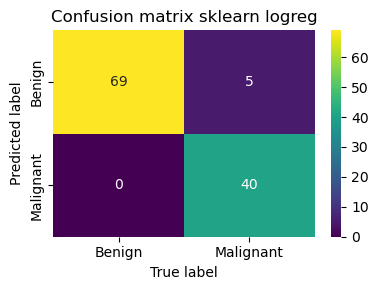

In [43]:
fig, ax = plt.subplots(figsize = (4, 3))
heatmap = sns.heatmap(conf_matrix, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(["Benign", "Malignant"])
heatmap.set_yticklabels(["Benign", "Malignant"])
ax.set_title("Confusion matrix sklearn logreg")
ax.set_ylabel("Predicted label")
ax.set_xlabel("True label")
plt.tight_layout()
plt.savefig(r"Figures\Task_d\Cancer_confusion_matrix_sklearn_logreg.png")
plt.show()